# Implement the Vision Transformer (ViT) in JAX.

##### Copyright 2021 Google LLC.

### Setup

Needs to be executed once in every VM.

The cell below downloads the code from Github and install necessary dependencies.

In [1]:
use_gdrive = 'no'  #@param ["yes", "no"] # Choose whether you would like to store data in your personal drive.
if use_gdrive == 'yes':
  from google.colab import drive
  drive.mount('/gdrive')
  root = '/gdrive/My Drive/vision_transformer_colab'
  import os
  if not os.path.isdir(root):
    os.mkdir(root)
  os.chdir(root)
  print(f'\nChanged CWD to "{root}"')
else:
  from IPython import display
![ -d vision_transformer ] || git clone --depth=1 https://github.com/google-research/vision_transformer # clone the repository
!cd vision_transformer && git pull
!pip install -qr vision_transformer/vit_jax/requirements.txt # get the required package

Already up to date.


### Imports

In [ ]:
# Shows all available pre-trained models.
!gsutil ls -lh gs://vit_models/imagenet*
!gsutil ls -lh gs://vit_models/sam
!gsutil ls -lh gs://mixer_models/*

gs://vit_models/imagenet21k+imagenet2012/:
377.57 MiB  2020-11-30T16:17:02Z  gs://vit_models/imagenet21k+imagenet2012/R50+ViT-B_16.npz
330.29 MiB  2020-10-29T17:05:52Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_16-224.npz
 331.4 MiB  2020-10-20T11:48:22Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_16.npz
336.89 MiB  2020-10-20T11:47:36Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_32.npz
334.78 MiB  2021-03-12T09:04:16Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_8.npz
  1.13 GiB  2020-10-29T17:08:31Z  gs://vit_models/imagenet21k+imagenet2012/ViT-L_16-224.npz
  1.14 GiB  2020-10-20T11:53:44Z  gs://vit_models/imagenet21k+imagenet2012/ViT-L_16.npz
  1.14 GiB  2020-10-20T11:50:56Z  gs://vit_models/imagenet21k+imagenet2012/ViT-L_32.npz

gs://vit_models/imagenet21k/:
450.23 MiB  2021-01-20T14:12:43Z  gs://vit_models/imagenet21k/R26+ViT-B_32.npz
439.85 MiB  2020-11-30T10:10:15Z  gs://vit_models/imagenet21k/R50+ViT-B_16.npz
  1.31 GiB  2021-01-20T14:11:54Z  gs://vit_models/ima

In [19]:
# Download a pre-trained model.

# Note: you can really choose any of the above, but this Colab has been tested
# with the models of below selection...
model_name = 'ViT-B_32'  #@param ["ViT-B_32", "Mixer-B_16"]

if model_name.startswith('ViT'):
  ![ -e "$model_name".npz ] || gsutil cp gs://vit_models/imagenet21k/"$model_name".npz .
if model_name.startswith('Mixer'):
  ![ -e "$model_name".npz ] || gsutil cp gs://mixer_models/imagenet21k/"$model_name".npz .

import os
assert os.path.exists(f'{model_name}.npz')

Copying gs://vit_models/imagenet21k/ViT-B_32.npz...
/ [1 files][400.0 MiB/400.0 MiB]                                                
Operation completed over 1 objects/400.0 MiB.                                    


In [4]:
# set up JAX with TPU
import os
if 'google.colab' in str(get_ipython()) and 'COLAB_TPU_ADDR' in os.environ:
  import jax
  import jax.tools.colab_tpu
  jax.tools.colab_tpu.setup_tpu()
  print('Connected to TPU.')
else:
  print('No TPU detected. Can be changed under "Runtime/Change runtime type".')

No TPU detected. Can be changed under "Runtime/Change runtime type".


In [1]:
from absl import logging
import flax
import jax
from matplotlib import pyplot as plt
import numpy as np
import optax
import tqdm

logging.set_verbosity(logging.INFO)

# Shows the number of available devices.
jax.local_devices()

[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0),
 StreamExecutorGpuDevice(id=1, process_index=0, slice_index=0)]

In [ ]:
# Open some code files in a split editor on the right.
# You can open more files in the file tab on the left.
from google.colab import files
files.view('vision_transformer/vit_jax/configs/common.py')
files.view('vision_transformer/vit_jax/configs/models.py')
files.view('vision_transformer/vit_jax/checkpoint.py')
files.view('vision_transformer/vit_jax/input_pipeline.py')
files.view('vision_transformer/vit_jax/models.py')
files.view('vision_transformer/vit_jax/train.py')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [6]:
# Import files from repository.
# Updating the files in the editor on the right will immediately update the
# modules by re-importing them.

import sys
if './vision_transformer' not in sys.path:
  sys.path.append('./vision_transformer')

%load_ext autoreload
%autoreload 2

from vit_jax import checkpoint
from vit_jax import input_pipeline
from vit_jax import utils
from vit_jax import models
from vit_jax import train
from vit_jax.configs import common as common_config
from vit_jax.configs import models as models_config

2022-11-13 02:02:06.543682: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-13 02:02:07.615807: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-13 02:02:07.615974: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-11-13 02:02:07.615990: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [7]:
# Helper functions 

labelnames = dict(
  # https://www.cs.toronto.edu/~kriz/cifar.html
  cifar10=('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'),
  # https://www.cs.toronto.edu/~kriz/cifar.html
  cifar100=('apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'computer_keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm')
)
def make_label_getter(dataset):
  """Returns a function converting label indices to names."""
  def getter(label):
    if dataset in labelnames:
      return labelnames[dataset][label]
    return f'label={label}'
  return getter

def show_img(img, ax=None, title=None):
  """Shows a single image."""
  if ax is None:
    ax = plt.gca()
  ax.imshow(img[...])
  ax.set_xticks([])
  ax.set_yticks([])
  if title:
    ax.set_title(title)

def show_img_grid(imgs, titles):
  """Shows a grid of images."""
  n = int(np.ceil(len(imgs)**.5))
  _, axs = plt.subplots(n, n, figsize=(3 * n, 3 * n))
  for i, (img, title) in enumerate(zip(imgs, titles)):
    img = (img + 1) / 2  # Denormalize
    show_img(img, axs[i // n][i % n], title)

### Load dataset

In [8]:
dataset = 'cifar10'
batch_size = 512
config = common_config.with_dataset(common_config.get_config(), dataset)
num_classes = input_pipeline.get_dataset_info(dataset, 'train')['num_classes']
config.batch = batch_size
config.pp.crop = 224

2022-11-13 02:02:15.673415: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".
INFO:absl:Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: cifar10/3.0.2
INFO:absl:Load dataset info from /tmp/tmpv3tj0j9jtfds
INFO:absl:Field info.citation from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.splits from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.supervised_keys from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.module_name from disk and from code do not match. Keeping the one from

In [9]:
# For details about setting up datasets, see input_pipeline.py on the right.
ds_train = input_pipeline.get_data_from_tfds(config=config, mode='train')
ds_test = input_pipeline.get_data_from_tfds(config=config, mode='test')

del config  # Only needed to instantiate datasets.

INFO:absl:Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: cifar10/3.0.2
INFO:absl:Load dataset info from /tmp/tmphu3eyk_7tfds
INFO:absl:Field info.citation from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.splits from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.supervised_keys from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.module_name from disk and from code do not match. Keeping the one from code.
INFO:absl:Generating dataset cifar10 (/home/yuslzp/tensorflow_datasets/cifar10/3.0.2)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

INFO:absl:Downloading https://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz into /home/yuslzp/tensorflow_datasets/downloads/cs.toronto.edu_kriz_cifar-10-binaryODHPtIjLh3oLcXirEISTO7dkzyKjRCuol6lV8Wc6C7s.tar.gz.tmp.2911a8b792184102904e67ac479a09b5...


Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

2022-11-13 02:02:29.583978: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_INVALID_DEVICE: invalid device ordinal


Shuffling /home/yuslzp/tensorflow_datasets/cifar10/3.0.2.incompleteMVCJQV/cifar10-train.tfrecord*...:   0%|   …

INFO:absl:Done writing /home/yuslzp/tensorflow_datasets/cifar10/3.0.2.incompleteMVCJQV/cifar10-train.tfrecord*. Number of examples: 50000 (shards: [50000])


Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /home/yuslzp/tensorflow_datasets/cifar10/3.0.2.incompleteMVCJQV/cifar10-test.tfrecord*...:   0%|    …

INFO:absl:Done writing /home/yuslzp/tensorflow_datasets/cifar10/3.0.2.incompleteMVCJQV/cifar10-test.tfrecord*. Number of examples: 10000 (shards: [10000])
INFO:absl:Constructing tf.data.Dataset cifar10 for split train[:98%], from /home/yuslzp/tensorflow_datasets/cifar10/3.0.2
INFO:absl:Load dataset info from /home/yuslzp/tensorflow_datasets/cifar10/3.0.2


Dataset cifar10 downloaded and prepared to /home/yuslzp/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


INFO:absl:Load dataset info from /home/yuslzp/tensorflow_datasets/cifar10/3.0.2
INFO:absl:Reusing dataset cifar10 (/home/yuslzp/tensorflow_datasets/cifar10/3.0.2)
INFO:absl:Constructing tf.data.Dataset cifar10 for split test, from /home/yuslzp/tensorflow_datasets/cifar10/3.0.2
INFO:absl:Load dataset info from /home/yuslzp/tensorflow_datasets/cifar10/3.0.2


In [10]:
# Fetch a batch of test images for illustration purposes.
batch = next(iter(ds_test.as_numpy_iterator()))
# Note the shape : [num_local_devices, local_batch_size, h, w, c]
batch['image'].shape

2022-11-13 02:06:44.079838: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(1, 512, 224, 224, 3)

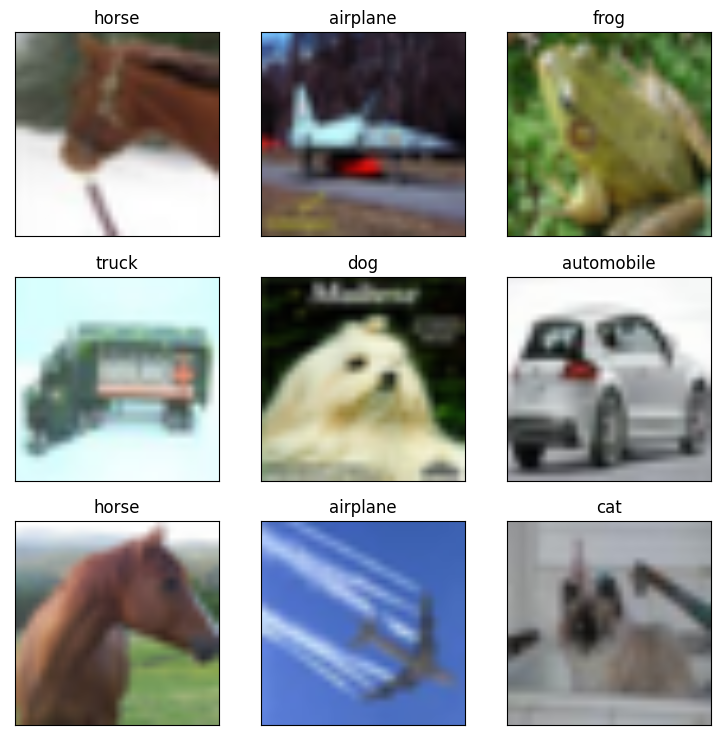

In [11]:
# Show some imags with their labels.
images, labels = batch['image'][0][:9], batch['label'][0][:9]
titles = map(make_label_getter(dataset), labels.argmax(axis=1))
show_img_grid(images, titles)

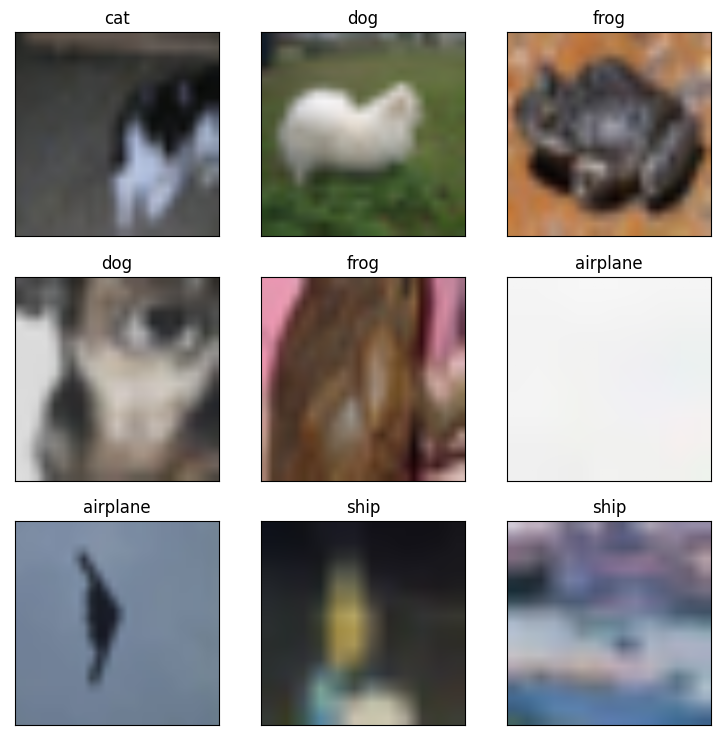

In [12]:
# Same as above, but with train images.
# Note how images are cropped/scaled differently.
# Check out input_pipeline.get_data() in the editor at your right to see how the
# images are preprocessed differently.
batch = next(iter(ds_train.as_numpy_iterator()))
images, labels = batch['image'][0][:9], batch['label'][0][:9]
titles = map(make_label_getter(dataset), labels.argmax(axis=1))
show_img_grid(images, titles)

### Load pre-trained

In [20]:
model_config = models_config.MODEL_CONFIGS[model_name]
model_config

classifier: token
hidden_size: 768
model_name: ViT-B_32
patches:
  size: !!python/tuple
  - 32
  - 32
representation_size: null
transformer:
  attention_dropout_rate: 0.0
  dropout_rate: 0.0
  mlp_dim: 3072
  num_heads: 12
  num_layers: 12

In [21]:
# Load model definition & initialize random parameters.
# This also compiles the model to XLA (takes some minutes the first time).
if model_name.startswith('Mixer'):
  model = models.MlpMixer(num_classes=num_classes, **model_config)
else:
  model = models.VisionTransformer(num_classes=num_classes, **model_config)
variables = jax.jit(lambda: model.init(
    jax.random.PRNGKey(0),
    # Discard the "num_local_devices" dimension of the batch for initialization.
    batch['image'][0, :1],
    train=False,
), backend='cpu')()

In [22]:
# Load and convert pretrained checkpoint.
# This involves loading the actual pre-trained model results, but then also also
# modifying the parameters a bit, e.g. changing the final layers, and resizing
# the positional embeddings.
# For details, refer to the code and to the methods of the paper.
params = checkpoint.load_pretrained(
    pretrained_path=f'{model_name}.npz',
    init_params=variables['params'],
    model_config=model_config,
)

INFO:absl:Inspect extra keys:
{'pre_logits/bias', 'pre_logits/kernel'}
INFO:absl:load_pretrained: drop-head variant


### Evaluate

In [24]:
# So far, all our data is in the host memory. Let's now replicate the arrays
# into the devices.
# This will make every array in the pytree params become a ShardedDeviceArray
# that has the same data replicated across all local devices.
# For TPU it replicates the params in every core.
# For a single GPU this simply moves the data onto the device.
# For CPU it simply creates a copy.
params_repl = flax.jax_utils.replicate(params)
print('params.cls:', type(params['head']['bias']).__name__,
      params['head']['bias'].shape)
print('params_repl.cls:', type(params_repl['head']['bias']).__name__,
      params_repl['head']['bias'].shape)

params.cls: DeviceArray (10,)
params_repl.cls: ShardedDeviceArray (1, 10)


In [25]:
# Then map the call to our model's forward pass onto all available devices.
vit_apply_repl = jax.pmap(lambda params, inputs: model.apply(
    dict(params=params), inputs, train=False))

In [26]:
def get_accuracy(params_repl):
  """Returns accuracy evaluated on the test set."""
  good = total = 0
  steps = input_pipeline.get_dataset_info(dataset, 'test')['num_examples'] // batch_size
  for _, batch in zip(tqdm.trange(steps), ds_test.as_numpy_iterator()):
    predicted = vit_apply_repl(params_repl, batch['image'])
    is_same = predicted.argmax(axis=-1) == batch['label'].argmax(axis=-1)
    good += is_same.sum()
    total += len(is_same.flatten())
  return good / total

In [27]:
# Random performance without fine-tuning.
get_accuracy(params_repl)

INFO:absl:Load dataset info from /home/yuslzp/tensorflow_datasets/cifar10/3.0.2
100%|██████████| 19/19 [03:53<00:00, 12.27s/it]


DeviceArray(0.10063734, dtype=float32)

### Fine-tune

In [28]:
# 100 Steps take approximately 15 minutes in the TPU runtime.
total_steps = 100
warmup_steps = 5
decay_type = 'cosine'
grad_norm_clip = 1
# This controls in how many forward passes the batch is split. 8 works well with
# a TPU runtime that has 8 devices. 64 should work on a GPU. You can of course
# also adjust the batch_size above, but that would require you to adjust the
# learning rate accordingly.
accum_steps = 8
base_lr = 0.03

In [29]:
# Check out train.make_update_fn in the editor on the right side for details.
lr_fn = utils.create_learning_rate_schedule(total_steps, base_lr, decay_type, warmup_steps)
# We use a momentum optimizer that uses half precision for state to save
# memory. It als implements the gradient clipping.
tx = optax.chain(
    optax.clip_by_global_norm(grad_norm_clip),
    optax.sgd(
        learning_rate=lr_fn,
        momentum=0.9,
        accumulator_dtype='bfloat16',
    ),
)
update_fn_repl = train.make_update_fn(
    apply_fn=model.apply, accum_steps=accum_steps, tx=tx)
opt_state = tx.init(params)
opt_state_repl = flax.jax_utils.replicate(opt_state)

In [30]:
# Initialize PRNGs for dropout.
update_rng_repl = flax.jax_utils.replicate(jax.random.PRNGKey(0))

In [31]:
losses = []
lrs = []
# Completes in ~20 min on the TPU runtime.
for step, batch in zip(
    tqdm.trange(1, total_steps + 1),
    ds_train.as_numpy_iterator(),
):

  params_repl, opt_state_repl, loss_repl, update_rng_repl = update_fn_repl(
      params_repl, opt_state_repl, batch, update_rng_repl)
  losses.append(loss_repl[0])
  lrs.append(lr_fn(step))

plt.plot(losses)
plt.figure()
plt.plot(lrs)

  0%|          | 0/100 [00:00<?, ?it/s]2022-11-13 02:52:59.007446: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module pmap_update_fn] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-11-13 02:54:35.820266: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 3m36.812832962s

********************************
[Compiling module pmap_update_fn] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
 12%|█▏        | 12/100 [37:39<4:03:33, 166.06s/it]

In [ ]:
# Should be ~96.7% for Mixer-B/16 or 97.7% for ViT-B/32 on CIFAR10 (both @224)
get_accuracy(params_repl)

INFO:absl:Load dataset info from ~/tensorflow_datasets/cifar10/3.0.2
100%|██████████| 19/19 [00:31<00:00,  1.64s/it]


DeviceArray(0.9767681, dtype=float32)

### Inference

In [ ]:
# Download a pre-trained model.

if model_name.startswith('Mixer'):
  # Download model trained on imagenet2012
  ![ -e "$model_name"_imagenet2012.npz ] || gsutil cp gs://mixer_models/imagenet1k/"$model_name".npz "$model_name"_imagenet2012.npz
  model = models.MlpMixer(num_classes=1000, **model_config)
else:
  # Download model pre-trained on imagenet21k and fine-tuned on imagenet2012.
  ![ -e "$model_name"_imagenet2012.npz ] || gsutil cp gs://vit_models/imagenet21k+imagenet2012/"$model_name".npz "$model_name"_imagenet2012.npz
  model = models.VisionTransformer(num_classes=1000, **model_config)

import os
assert os.path.exists(f'{model_name}_imagenet2012.npz')

NameError: name 'model_name' is not defined

In [ ]:
# Load and convert pretrained checkpoint.
params = checkpoint.load(f'{model_name}_imagenet2012.npz')
params['pre_logits'] = {}  # Need to restore empty leaf for Flax.

In [ ]:
# Get imagenet labels.
!wget https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
imagenet_labels = dict(enumerate(open('ilsvrc2012_wordnet_lemmas.txt')))

--2022-10-29 23:21:49--  https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.28.128, 74.125.134.128, 173.194.210.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.28.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21675 (21K) [text/plain]
Saving to: ‘ilsvrc2012_wordnet_lemmas.txt’

ilsvrc2012_wordnet_ 100%[===================>]  21.17K  --.-KB/s    in 0s      

2022-10-29 23:21:49 (88.4 MB/s) - ‘ilsvrc2012_wordnet_lemmas.txt’ saved [21675/21675]



In [ ]:
# Get a random picture with the correct dimensions.
resolution = 224 if model_name.startswith('Mixer') else 384
!wget https://picsum.photos/$resolution -O picsum.jpg
import PIL
img = PIL.Image.open('picsum.jpg')
img

NameError: name 'model_name' is not defined

In [ ]:
# Predict on a batch with a single item (note very efficient TPU usage...)
logits, = model.apply(dict(params=params), (np.array(img) / 128 - 1)[None, ...], train=False)

NameError: name 'model' is not defined

In [ ]:
preds = np.array(jax.nn.softmax(logits))
for idx in preds.argsort()[:-11:-1]:
  print(f'{preds[idx]:.5f} : {imagenet_labels[idx]}', end='')

0.11499 : cellular_telephone, cellular_phone, cellphone, cell, mobile_phone
0.11436 : television, television_system
0.06890 : hand-held_computer, hand-held_microcomputer
0.06327 : printer
0.05348 : paintbrush
0.03909 : iPod
0.02630 : monitor
0.02581 : screen, CRT_screen
0.01892 : laptop, laptop_computer
0.01783 : notebook, notebook_computer
